In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target
cancer_df = pd.DataFrame(data = X_features, columns=dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [3]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.20, stratify=y_label, random_state=1)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [5]:
import xgboost as xgb
from xgboost import plot_importance
dtrain = xgb.DMatrix(data = X_train, label = y_train)
dtest = xgb.DMatrix(data = X_test, label = y_test)

In [6]:
params = {'max_depth':3,
          'eta':0.1,
          'objective':'binary:logistic',
          'eval_metric':'logloss',
          'early_stoppings':100
         }

num_rounds = 400

In [7]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기합니다.
wlist = [(dtrain, 'train'), (dtest, 'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = num_rounds, early_stopping_rounds=100, evals=wlist)

[23:29:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { early_stoppings } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.61038	eval-logloss:0.61342
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.54198	eval-logloss:0.55143
[2]	train-logloss:0.48482	eval-logloss:0.49610
[3]	train-logloss:0.43457	eval-logloss:0.44726
[4]	train-logloss:0.39219	eval-logloss:0.40881
[5]	train-logloss:0.35600	eval-logloss:0.37416
[6]	train-logloss:0.32299	eval-logloss:0.34252
[7]	train-logloss:0.29481	eval-logloss:0.31901
[8]	train-logloss:0.26855	eval-logloss:0.29419
[9]	train-logloss:0.24573	eval-log

In [8]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만표시, 예측  확률값으로만 표시됨')
print(np.round(pred_probs[:10], 3))

#예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시: ', preds[:10])

predict() 수행 결과값을 10개만표시, 예측  확률값으로만 표시됨
[0.999 0.003 0.998 0.999 0.001 0.999 0.999 1.    0.    1.   ]
예측값 10개만 표시:  [1, 0, 1, 1, 0, 1, 1, 1, 0, 1]


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, preds, pred_probs):
    confusion = confusion_matrix(y_true = y_test, y_pred = preds)
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds, pred_probs)
    recall = recall_score(y_test, preds, pred_probs)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [10]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[40  2]
 [ 1 71]]
정확도: 0.9737, 정밀도: 0.9726, 재현율: 0.9861


In [11]:
# 오차 행렬
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_true = y_test, y_pred = preds)
print(confusion)

[[40  2]
 [ 1 71]]


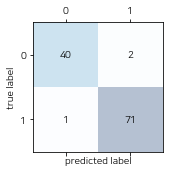

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confusion, cmap=plt.cm.Blues, alpha = 0.3)
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        ax.text(x=j, y=i,
               s=confusion[i,j],
               va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.tight_layout()
plt.show()

In [13]:
# 정밀도 재현율 최적화
from sklearn.metrics import precision_score, recall_score, f1_score
print('정확도: %.3f' % accuracy_score(y_test, preds))
print('정밀도: %.3f' % precision_score(y_test, preds, pred_probs))
print('재현율: %.3f' % recall_score(y_test, preds, pred_probs))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=preds))

정확도: 0.974
정밀도: 0.973
재현율: 0.986
F1: 0.979


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

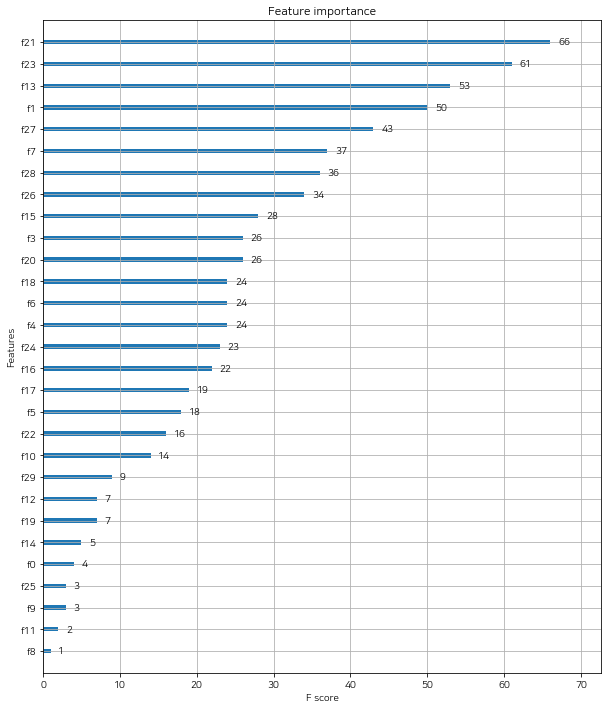

In [14]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)